Training new model...


Map:   0%|          | 0/35700 [00:00<?, ? examples/s]

Epoch 1, Loss: 0.0542
Epoch 2, Loss: 0.0289
Epoch 3, Loss: 0.0251
Epoch 4, Loss: 0.0242
Epoch 5, Loss: 0.0222
Epoch 6, Loss: 0.0203
Epoch 7, Loss: 0.0203
Epoch 8, Loss: 0.0178
Epoch 9, Loss: 0.0153
Epoch 10, Loss: 0.0137
Validation Loss: 0.0303
MSE: 0.0357
MAE: 0.1148
RMSE: 0.1889
R²: 0.5803


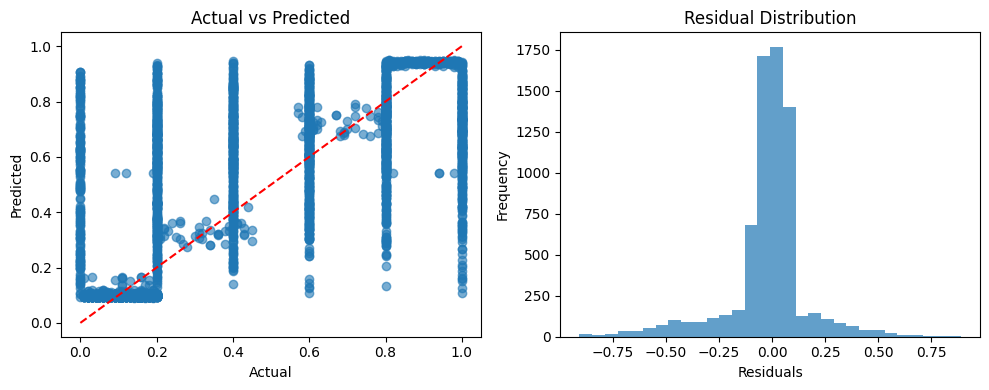

In [5]:
import kagglehub
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


class CredibilityRegressor(nn.Module):
    def __init__(self, pretrained_model='huawei-noah/TinyBERT_General_4L_312D'):
        super().__init__()
        self.config = AutoConfig.from_pretrained(pretrained_model)
        self.bert = AutoModel.from_pretrained(pretrained_model, config=self.config)

        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=self.config.hidden_size,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.sensationalism_features = nn.Sequential(
            nn.Linear(self.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64)
        )

        self.attention_weights = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.linguistic_patterns = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64)
        )

        self.emotional_intensity = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.feature_fusion = nn.Sequential(
            nn.Linear(64 + 64 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.credibility_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_states = outputs.last_hidden_state

        attn_output, _ = self.multi_head_attention(hidden_states, hidden_states, hidden_states,
                                                   key_padding_mask=~attention_mask.bool())

        weights = self.attention_weights(attn_output)
        weights = weights.masked_fill(attention_mask.unsqueeze(-1) == 0, float('-inf'))
        weights = torch.softmax(weights, dim=1)
        pooled_output = (attn_output * weights).sum(dim=1)

        cls_token = attn_output[:, 0, :]

        sensationalism_feat = self.sensationalism_features(pooled_output)
        linguistic_feat = self.linguistic_patterns(cls_token)
        emotional_feat = self.emotional_intensity(pooled_output)

        combined_features = torch.cat([sensationalism_feat, linguistic_feat, emotional_feat], dim=1)
        fused_features = self.feature_fusion(combined_features)

        score = self.credibility_head(fused_features).squeeze()

        loss = None
        if labels is not None:
            mse_loss = F.mse_loss(score, labels)
            huber_loss = F.smooth_l1_loss(score, labels)
            loss = 0.7 * mse_loss + 0.3 * huber_loss

        return {'loss': loss, 'score': score}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Training new model...")

path = kagglehub.dataset_download("doanquanvietnamca/liar-dataset")
csv_path = os.path.join(path, "train.tsv")
df_liar = pd.read_csv(csv_path, sep='\t', header=None)

df_liar = df_liar[[1, 2]]
df_liar.columns = ['label', 'statement']

label_map = {
    "pants-fire": 0.0,
    "false": 0.2,
    "barely-true": 0.4,
    "half-true": 0.6,
    "mostly-true": 0.8,
    "true": 1.0
}
df_liar = df_liar[df_liar['label'].isin(label_map)]
df_liar['credibility_score'] = df_liar['label'].map(label_map)
df_liar = df_liar[['statement', 'credibility_score']]

custom_dataset_path = "../custom_financial_news_credibility.csv"
df_custom = pd.read_csv(custom_dataset_path)
df_custom.columns = ['statement', 'credibility_score']

df_custom_2x = pd.concat([df_custom, df_custom], ignore_index=True)
df_combined = pd.concat([df_liar, df_custom_2x], ignore_index=True)

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")


def tokenize(example):
    tokens = tokenizer(
        example["statement"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    return {**tokens, "label": example["credibility_score"]}


raw_dataset = Dataset.from_pandas(df_combined)
dataset = raw_dataset.map(tokenize)

train_test = dataset.train_test_split(test_size=0.2)
train_dataset = train_test["train"]
val_dataset = train_test["test"]


def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch])
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.float)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

model = CredibilityRegressor().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
total_val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_val_loss += outputs["loss"].item()
print(f"Validation Loss: {total_val_loss / len(val_loader):.4f}")


def predict(texts):
    model.eval()
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        scores = model(input_ids=encoded['input_ids'], attention_mask=encoded['attention_mask'],
                       token_type_ids=encoded.get('token_type_ids'))["score"]
    return scores.cpu().numpy().tolist()


def evaluate_model():
    model.eval()
    predictions = []
    actual = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            scores = outputs["score"]

            predictions.extend(scores.cpu().numpy())
            actual.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actual = np.array(actual)

    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(actual, predictions, alpha=0.6)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    plt.subplot(1, 2, 2)
    residuals = actual - predictions
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')

    plt.tight_layout()
    plt.show()


evaluate_model()


In [ ]:
import os
print(os.getcwd())
